In [1]:
import math
import pandas as pd
import numpy as np
import time
from datetime import datetime
import copy
import os
import random
from typing import Optional, Any, Union, Callable, Tuple

import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import _in_projection_packed
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.offline as pyo
from d2l import torch as d2l

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import defaultdict
from scipy import stats

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

class myjoint(sns.JointGrid):
    def __init__(self, x, y, data=None,height=7, ratio=5, space=.2,
                 dropna=True, xlim=None, ylim=None, size=None):
        super(myjoint, self).__init__(x, y, data,height, ratio, space,
                 dropna, xlim, ylim, size)
        plt.close(2)
        # Set up the subplot grid
        self.ax_joint = f.add_subplot(gs[1:, :-1])
        self.ax_marg_x = f.add_subplot(gs[0, :-1], sharex=self.ax_joint)
        self.ax_marg_y = f.add_subplot(gs[1:, -1], sharey=self.ax_joint)

        # Turn off tick visibility for the measure axis on the marginal plots
        plt.setp(self.ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(self.ax_marg_y.get_yticklabels(), visible=False)

In [3]:
df=pd.read_csv("dataset2.csv")
#df = df.rename(columns={'vol_future': 'value'})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])
df.index = pd.to_datetime(df.index)

In [4]:
df.columns

Index(['etom_flow_total', 'etom_transactions_count_flow', 'etom_flow_mean',
       'mtoe_flow_total', 'mtoe_transactions_count_flow', 'mtoe_flow_mean',
       'exchange_addresses_count_inflow', 'exchange_addresses_count_outflow',
       'exchange_inflow_total', 'exchange_inflow_top10',
       'exchange_inflow_mean', 'exchange_inflow_mean_ma7',
       'exchange_transactions_count_inflow',
       'exchange_transactions_count_outflow', 'exchange_whale_ratio',
       'fund_flow_ratio', 'mpi', 'miner_addresses_count_inflow',
       'miner_addresses_count_outflow', 'miner_inflow_total',
       'miner_inflow_top10', 'miner_inflow_mean', 'miner_inflow_mean_ma7',
       'miner_outflow_total', 'miner_outflow_top10', 'miner_outflow_mean',
       'miner_outflow_mean_ma7', 'miner_transactions_count_inflow',
       'miner_transactions_count_outflow', 'market_cap', 'long_liquidations',
       'short_liquidations', 'long_liquidations_usd', 'short_liquidations_usd',
       'open', 'high', 'low', 'close

In [5]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 314

# CONVERT TO INDICES
split_time_1 = len(df) - (test_size)

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]

test_idx = df.index[split_time_1:]

In [6]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')

print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2016-01-02 00:00:00 	to: 2020-11-11 00:00:00 	1776 days
TEST 		From: 2020-11-12 00:00:00 	to: 2021-09-21 00:00:00 	314 days


In [7]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
#y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [8]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_future[train_idx]
#x_val = df.vol_current[val_idx]
x_test = df.vol_future[test_idx]

In [9]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
#r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [10]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
#lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [11]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [12]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [13]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)


# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [14]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output


# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output


def mae(y_true, y_pred):
    output=  np.mean(np.abs(y_true - y_pred))
    return output


# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Test RMSPE', 'Test RMSE','Test MAE'])


# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred),
                                       mae(y_true,y_pred)]
    
    return perf_df



In [15]:
from arch import arch_model
seed = 2021

In [16]:
#gm_1 = arch_model(lr_train, vol='GARCH', p=1, q=1)
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4829.96
Distribution:                  Normal   AIC:                           9667.92
Method:            Maximum Likelihood   BIC:                           9689.85
                                        No. Observations:                 1776
Date:                Mon, Sep 26 2022   Df Residuals:                     1775
Time:                        19:44:32   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2507  7.483e-02      3.350  8.076e-04 [  0.104,  0.3

In [17]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [18]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [19]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

In [20]:
INTERVAL_WINDOW = 2
n_future = 1

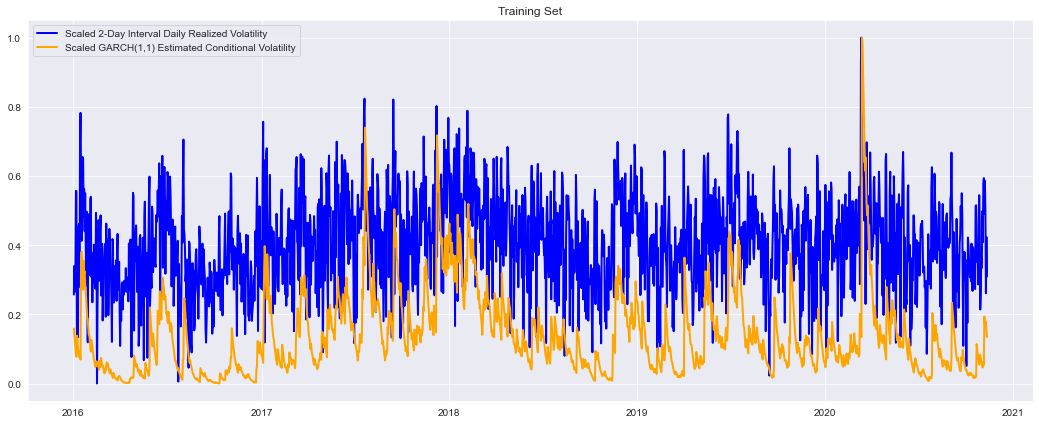

In [21]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

In [22]:
# ROLLING FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(test_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = test_idx[i]
    #train = df.log_returns[:idx]
    train = df.returns[:idx]
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))
    
    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=test_idx)

In [23]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

In [24]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_test_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

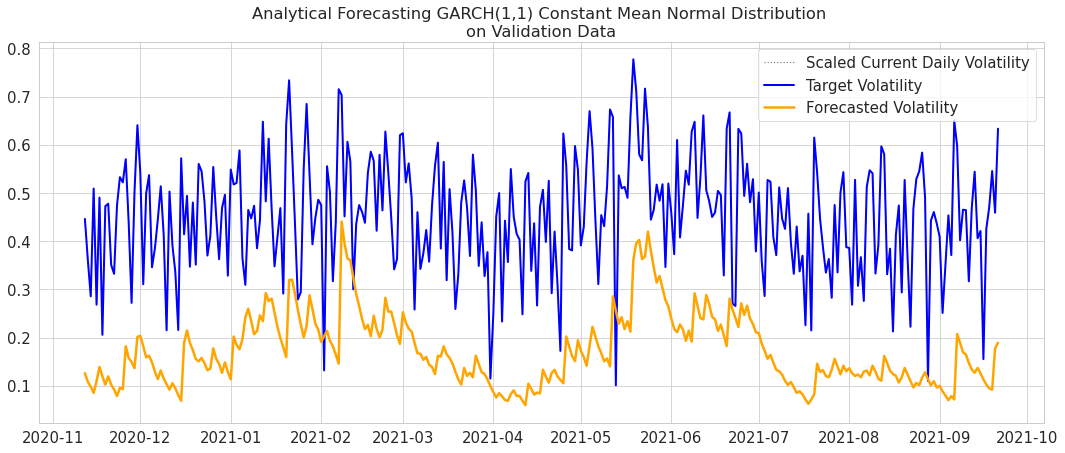

In [25]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_test_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

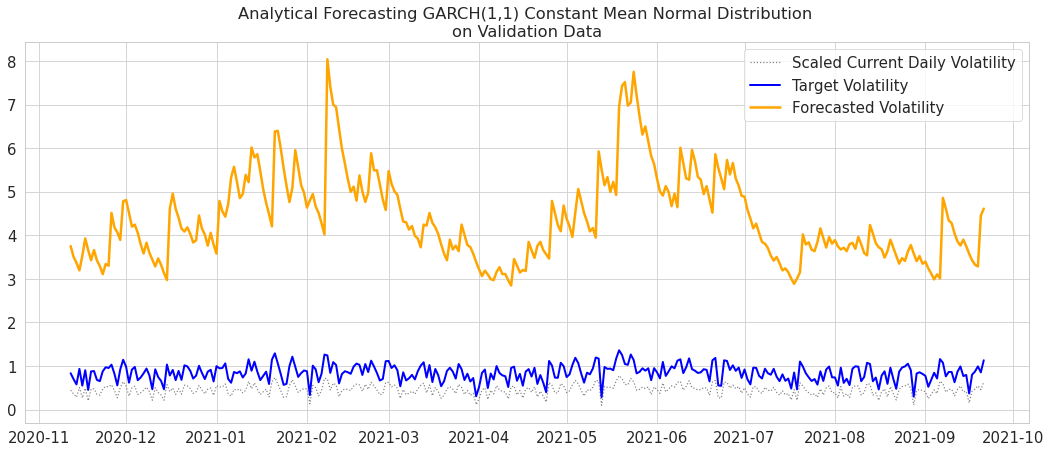

In [26]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_test, gm_1_preds, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [27]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_test, gm_1_preds, 
         'GARCH(1,1), Constant Mean, Normal Dist')

,Model,Test RMSPE,Test RMSE,Test MAE
0,"GARCH(1,1), Constant Mean, Normal Dist",4.762285,3.668467,3.541575


In [28]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_test_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

,Model,Test RMSPE,Test RMSE,Test MAE
0,"GARCH(1,1), Constant Mean, Normal Dist",4.762285,3.668467,3.541575
1,"GARCH(1,1), Constant Mean, Normal Dist",0.634354,0.303838,0.282251


In [29]:
gm_1_preds_scaled.describe()

count    314.000000
mean       0.172672
std        0.074192
min        0.059661
25%        0.117582
50%        0.156294
75%        0.217321
max        0.440918
dtype: float64

In [30]:
gm_1_preds.describe()

count    314.000000
mean       4.387095
std        1.010672
min        2.847633
25%        3.636646
50%        4.163989
75%        4.995315
max        8.041223
dtype: float64

In [31]:
y_test

date
2020-11-12    0.834208
2020-11-13    0.699357
2020-11-14    0.578436
2020-11-15    0.934486
2020-11-16    0.550836
                ...   
2021-09-17    0.801553
2021-09-18    0.873800
2021-09-19    0.992394
2021-09-20    0.854799
2021-09-21    1.132250
Name: vol_future, Length: 314, dtype: float64

In [32]:
y_test_scaled

date
2020-11-12    0.446201
2020-11-13    0.361512
2020-11-14    0.285570
2020-11-15    0.509178
2020-11-16    0.268237
                ...   
2021-09-17    0.425693
2021-09-18    0.471066
2021-09-19    0.545546
2021-09-20    0.459133
2021-09-21    0.633379
Length: 314, dtype: float64